# Clustering



## 1. Clustering

### Objective
- Understand **K-means** by building it from scratch.
- Perform **cluster analysis** on real data.
- Practice **model selection** (elbow, silhouette) and dimensionality reduction (PCA).

In [1]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn optional utilities
try:
    from sklearn.datasets import make_blobs # first dataset
    from sklearn.decomposition import PCA # principal component analysis
    from sklearn.preprocessing import StandardScaler
    from sklearn.manifold import TSNE
    from sklearn.cluster import DBSCAN
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

np.random.seed(42)

# Matplotlib Preferences
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

print("scikit-learn available:", SKLEARN_AVAILABLE)

scikit-learn available: True


## 2. K-means Scratch

### Problem 1 - Initializing the K centers

### Problem 2 - SSE Function
Within-cluster sum of squared errors (SSE):


In [2]:
class ScratchKMeans:
    """
    Scratch implementation of K-means clustering.

    Parameters
    ----------
    n_clusters : int
        Number of clusters (K).
    n_init : int
        Number of different centroid seeds to try; the best (lowest SSE) is kept.
    max_iter : int
        Maximum iterations per run.
    tol : float
        Convergence tolerance on total centroid shift.
    verbose : bool
        If True, prints progress.

    Attributes
    ----------
    cluster_centers_ : ndarray of shape (K, n_features)
        Final cluster centroids.
    labels_ : ndarray of shape (n_samples,)
        Labels of each point (0..K-1) for the training data.
    inertia_ : float
        Best SSE (sum of squared distances to nearest cluster center).
    inertia_history_ : list of floats
        SSE per iteration for the best run.
    """

    def __init__(self, n_clusters, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        self.n_clusters = int(n_clusters)
        self.n_init = int(n_init)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.verbose = bool(verbose)

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.inertia_history_ = None

    # Problem 1
    def _init_centers(self, X, rng):
        """Pick K distinct points from X as initial centers."""
        n_samples = X.shape[0]
        if self.n_clusters > n_samples:
            raise ValueError("n_clusters cannot exceed number of samples")
        idx = rng.choice(n_samples, size=self.n_clusters, replace=False)
        return X[idx].copy()

    # Problem 3
    @staticmethod
    def _assign_clusters(X, centers):
        """Assign each point to nearest center (Euclidean). Returns labels and squared distances."""
        # squared distances: (x - mu)^2 = x^2 + mu^2 - 2 x·mu
        # Use broadcasting to compute pairwise squared distances
        # X: (N,d), centers: (K,d) -> dist2: (N,K)
        x2 = np.sum(X**2, axis=1, keepdims=True)          # (N,1)
        c2 = np.sum(centers**2, axis=1, keepdims=True).T  # (1,K)
        dist2 = x2 + c2 - 2 * (X @ centers.T)
        labels = np.argmin(dist2, axis=1)
        min_dist2 = dist2[np.arange(X.shape[0]), labels]
        return labels, min_dist2

    # Problem 4
    def _update_centers(self, X, labels, old_centers, rng):
        """Recompute centers as means. Handle empty clusters by re-sampling a random point."""
        K = self.n_clusters
        d = X.shape[1]
        new_centers = np.zeros((K, d), dtype=float)
        for k in range(K):
            mask = (labels == k)
            if np.any(mask):
                new_centers[k] = X[mask].mean(axis=0)
            else:
                # Empty cluster: reinitialize to a random data point
                new_centers[k] = X[rng.integers(0, X.shape[0])]
        shift = float(np.linalg.norm(new_centers - old_centers, ord='fro'))
        return new_centers, shift

    # Problem 2
    @staticmethod
    def _sse_from_labels(X, centers, labels):
        _, min_dist2 = ScratchKMeans._assign_clusters(X, centers)
        return float(np.sum(min_dist2))

    # Problem 5,6
    def fit(self, X):
        """
        Run K-means clustering with multiple initializations; keep best by SSE.
        """
        X = np.asarray(X, dtype=float)
        best_sse = np.inf
        best_centers = None
        best_labels = None
        best_history = None

        for run in range(self.n_init):
            rng = np.random.default_rng(seed=42 + run)
            centers = self._init_centers(X, rng)
            history = []

            for it in range(self.max_iter):
                labels, _ = self._assign_clusters(X, centers)
                new_centers, shift = self._update_centers(X, labels, centers, rng)
                sse = self._sse_from_labels(X, new_centers, labels)
                history.append(sse)
                centers = new_centers

                if self.verbose and (it % max(1, self.max_iter // 10) == 0 or it == self.max_iter - 1):
                    print(f"[run {run+1}/{self.n_init}] iter {it+1:4d}/{self.max_iter}  SSE={sse:.6f}  shift={shift:.6e}")

                if shift <= self.tol:
                    break

            # Keep best run
            if sse < best_sse:
                best_sse = sse
                best_centers = centers.copy()
                best_labels = labels.copy()
                best_history = history

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_sse
        self.inertia_history_ = best_history
        return self

    # Problem 7
    def predict(self, X):
        """
        Assign nearest cluster index for each row in X.
        """
        X = np.asarray(X, dtype=float)
        labels, _ = self._assign_clusters(X, self.cluster_centers_)
        return labels

    # convenience
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## 3. Blobs Data


SSE (best run): 135.39229388282507


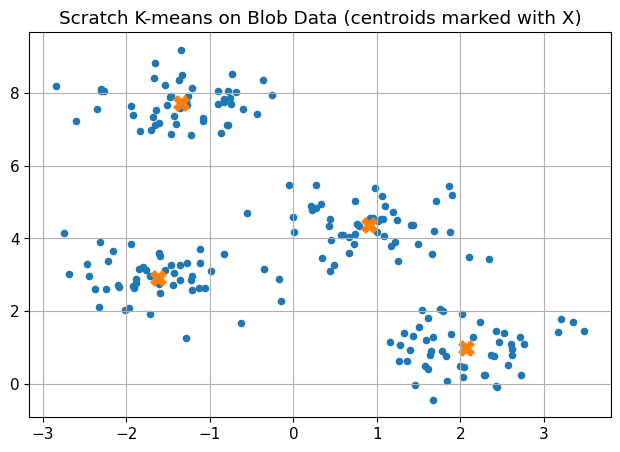

In [4]:
def make_simple_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, random_state=0):
    if not SKLEARN_AVAILABLE:
        # Manual blob generator
        rng = np.random.default_rng(random_state)
        centers_pts = rng.uniform(-5, 5, size=(centers, n_features))
        counts = [n_samples // centers] * centers
        for i in range(n_samples % centers):
            counts[i] += 1
        X_parts = []
        for i, c in enumerate(counts):
            X_parts.append(centers_pts[i] + rng.normal(0, cluster_std, size=(c, n_features)))
        return np.vstack(X_parts)
    else:
        X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                          cluster_std=cluster_std, shuffle=True, random_state=random_state)
        return X

X_blobs = make_simple_blobs(n_samples=200, centers=4, cluster_std=0.6, random_state=0)

km = ScratchKMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-4, verbose=False)
labels_blobs = km.fit_predict(X_blobs)
print("SSE (best run):", km.inertia_)

# Visualize clusters (note: labels are arbitrary, just to see separation)
fig = plt.figure()
plt.scatter(X_blobs[:,0], X_blobs[:,1], s=20)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=120, marker="X")
plt.title("Scratch K-means on Blob Data (centroids marked with X)")
plt.show()

## 4. Model Selection Tools

### Problem 8 - Elbow Method


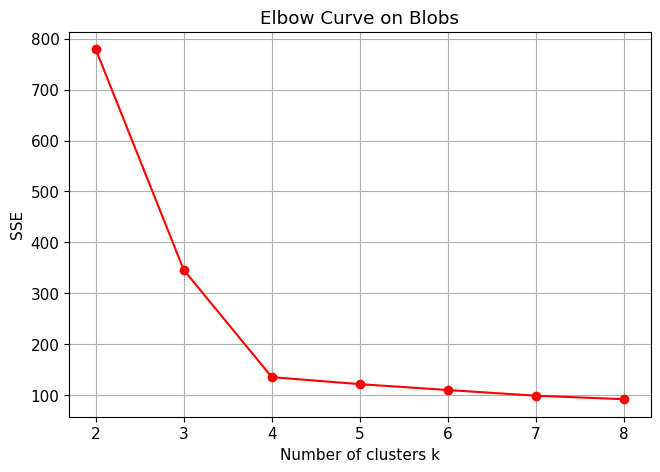

In [7]:
def elbow_curve(X, k_values, n_init=5, max_iter=200, tol=1e-4):
    sse_list = []
    for k in k_values:
        km = ScratchKMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, tol=tol, verbose=False)
        km.fit(X)
        sse_list.append(km.inertia_)
    return np.array(k_values), np.array(sse_list)

k_vals, sse_vals = elbow_curve(X_blobs, k_values=range(2,9))
fig = plt.figure()
plt.plot(k_vals, sse_vals, marker="o", color="red")
plt.xlabel("Number of clusters k")
plt.ylabel("SSE")
plt.title("Elbow Curve on Blobs")
plt.show()

### Problem 9 - Silhouette Diagram


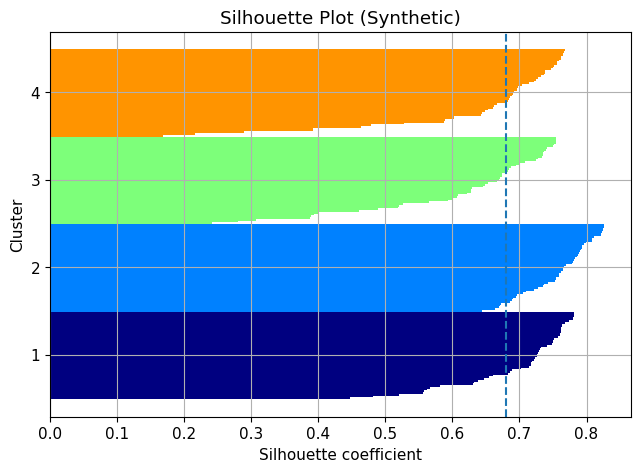

Average silhouette score: 0.6805896465958889


In [8]:
def pairwise_distances(X):
    # Efficient Euclidean pairwise distances using (x - y)^2 expansion
    x2 = np.sum(X**2, axis=1, keepdims=True)
    dist2 = x2 + x2.T - 2 * (X @ X.T)
    np.maximum(dist2, 0.0, out=dist2)
    return np.sqrt(dist2, out=dist2)

def silhouette_scores(X, labels):
    X = np.asarray(X, dtype=float)
    labels = np.asarray(labels)
    N = X.shape[0]
    D = pairwise_distances(X)

    s_vals = np.zeros(N, dtype=float)
    unique_labels = np.unique(labels)

    for i in range(N):
        c = labels[i]
        in_cluster = (labels == c)
        # a: average distance to same cluster (exclude self)
        if np.sum(in_cluster) > 1:
            a = np.mean(D[i, in_cluster][D[i, in_cluster] > 0])
        else:
            a = 0.0  # singleton cluster

        # b: min average distance to other clusters
        b = np.inf
        for c2 in unique_labels:
            if c2 == c:
                continue
            mask = (labels == c2)
            if np.any(mask):
                b = min(b, float(np.mean(D[i, mask])))
        if not np.isfinite(b):
            b = 0.0

        denom = max(a, b)
        s = 0.0 if denom == 0 else (b - a) / denom
        s_vals[i] = s

    return s_vals, float(np.mean(s_vals))

# Compute for current synthetic clustering
sil_vals, sil_avg = silhouette_scores(X_blobs, labels_blobs)

# Provided plotting scaffold
from matplotlib import cm

cluster_labels = np.unique(labels_blobs)
n_clusters = len(cluster_labels)

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = sil_vals[labels_blobs == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)  # allowed: we are not setting a specific color name; cm handles it
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(sil_avg, linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette Plot (Synthetic)")
plt.show()

print("Average silhouette score:", sil_avg)

## 5. Cluster Analysis - Wholesale Customers

We use **Wholesale customers data.csv** (Lisbon wholesaler). We drop the categorical columns `Channel` and `Region`, scale the 6 monetary features, reduce to 2D via **PCA** for visualization, and run K-means.

Columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
PCA shape: (440, 2)
Cumulative explained variance (first 6): [0.44082893 0.72459292 0.84793705 0.94189209 0.98950481 1.        ]


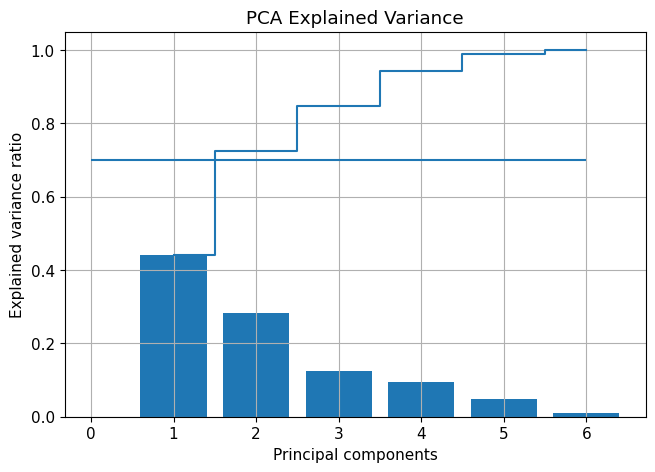

In [9]:
# Load the dataset from the provided path (already uploaded)
data_path = "/content/Wholesale customers data.csv" # path
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

df = pd.read_csv(data_path)
print("Columns:", df.columns.tolist())
df_orig = df.copy()

# Drop Channel/Region for clustering features
feature_cols = [c for c in df.columns if c.lower() not in ("channel", "region")]
data = df[feature_cols].values.astype(float)

# Scale
if SKLEARN_AVAILABLE:
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
else:
    mu = data.mean(axis=0, keepdims=True)
    sd = data.std(axis=0, keepdims=True) + 1e-8
    data_scaled = (data - mu) / sd

# PCA to 2 components for visualization & elbow/silhouette on 2D
def pca_2d(X):
    if SKLEARN_AVAILABLE:
        p = PCA(n_components=2)
        return p.fit_transform(X), p
    # fallback SVD PCA
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = U[:, :2] * S[:2]
    class SimplePCA: pass
    p = SimplePCA()
    p.explained_variance_ratio_ = (S**2) / np.sum(S**2)
    return Z, p

data_pca, pca_model = pca_2d(data_scaled)
print("PCA shape:", data_pca.shape)

# Explained variance plot (full if sklearn PCA, else from SVD ratio)
if SKLEARN_AVAILABLE:
    p = PCA(n_components=None).fit(data_scaled)
    var_exp = p.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
else:
    # Use SVD fallback to approximate full spectrum
    Xc = data_scaled - data_scaled.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    var_exp = (S**2) / np.sum(S**2)
    cum_var_exp = np.cumsum(var_exp)

print("Cumulative explained variance (first 6):", cum_var_exp[:6])

fig = plt.figure()
plt.bar(range(1, len(var_exp)+1), var_exp, align='center')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, len(var_exp))
plt.title("PCA Explained Variance")
plt.show()

### Problem 10 - Choosing \(k\)


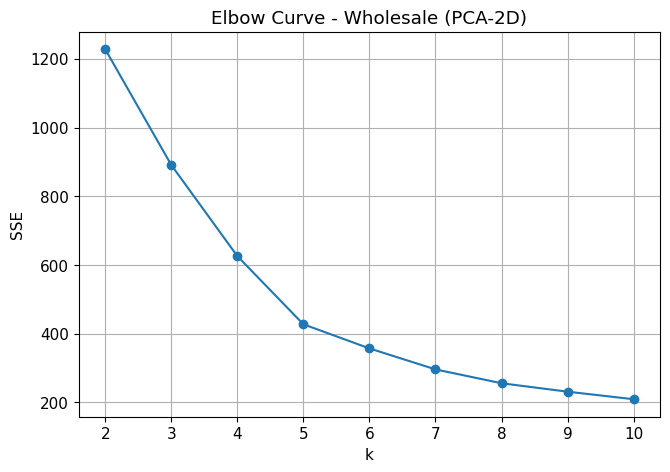

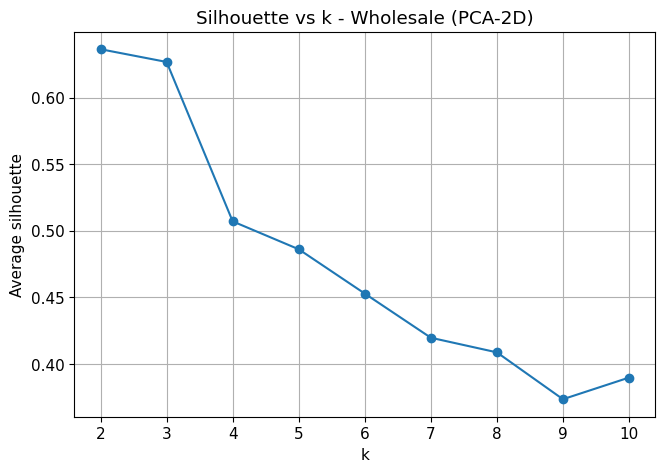

Heuristic elbow-k: 10  | best silhouette-k: 2


In [10]:
k_values = list(range(2, 11))
k_vals_wh, sse_vals_wh = elbow_curve(data_pca, k_values=k_values, n_init=8, max_iter=300, tol=1e-4)

fig = plt.figure()
plt.plot(k_vals_wh, sse_vals_wh, marker="o")
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow Curve - Wholesale (PCA-2D)")
plt.show()

# Silhouette for each k
silhouette_avgs = []
for k in k_values:
    km_k = ScratchKMeans(n_clusters=k, n_init=8, max_iter=300, tol=1e-4)
    labels_k = km_k.fit_predict(data_pca)
    sil_vals_k, sil_avg_k = silhouette_scores(data_pca, labels_k)
    silhouette_avgs.append(sil_avg_k)

fig = plt.figure()
plt.plot(k_values, silhouette_avgs, marker="o")
plt.xlabel("k")
plt.ylabel("Average silhouette")
plt.title("Silhouette vs k - Wholesale (PCA-2D)")
plt.show()

best_k_elbow = int(k_vals_wh[np.argmin(np.gradient(np.gradient(sse_vals_wh)))]) if len(k_vals_wh) >= 3 else int(k_vals_wh[np.argmin(sse_vals_wh)])
best_k_sil = int(k_values[int(np.argmax(silhouette_avgs))])
print("Heuristic elbow-k:", best_k_elbow, " | best silhouette-k:", best_k_sil)

### Fit chosen K and visualize clusters on PCA-2D


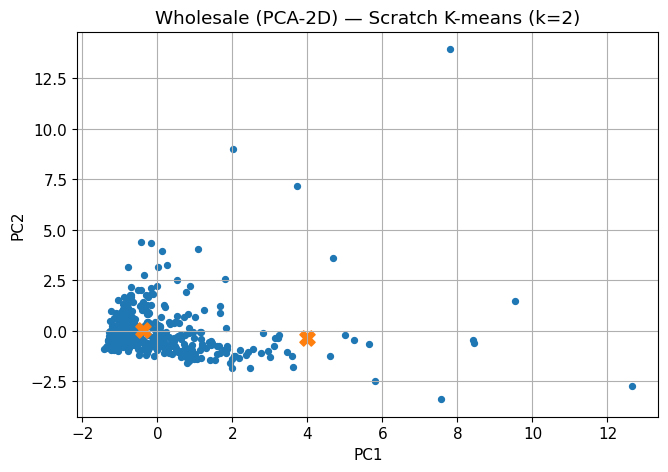

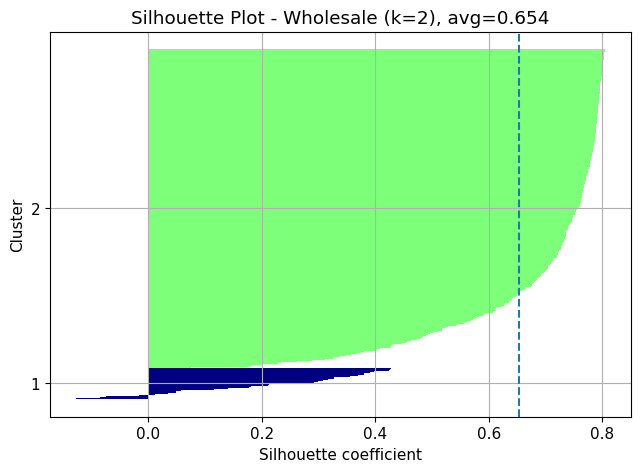

In [11]:
# Choose k
k_chosen = best_k_sil

km_wh = ScratchKMeans(n_clusters=k_chosen, n_init=10, max_iter=500, tol=1e-4, verbose=False)
labels_wh = km_wh.fit_predict(data_pca)

fig = plt.figure()
plt.scatter(data_pca[:,0], data_pca[:,1], s=18)
plt.scatter(km_wh.cluster_centers_[:,0], km_wh.cluster_centers_[:,1], s=120, marker="X")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Wholesale (PCA-2D) — Scratch K-means (k={k_chosen})")
plt.show()

# Silhouette plot for final k
sil_vals_wh, sil_avg_wh = silhouette_scores(data_pca, labels_wh)
from matplotlib import cm

cluster_labels = np.unique(labels_wh)
n_clusters = len(cluster_labels)

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = sil_vals_wh[labels_wh == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(sil_avg_wh, linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title(f"Silhouette Plot - Wholesale (k={k_chosen}), avg={sil_avg_wh:.3f}")
plt.show()

### Problem 11 - Compare Clusters with Known Groups (Channel / Region)


Cluster vs Channel:
 Channel    1    2
cluster          
0          2   37
1        296  105 

Cluster vs Region:
 Region    1   2    3
cluster             
0         7   8   24
1        70  39  292 



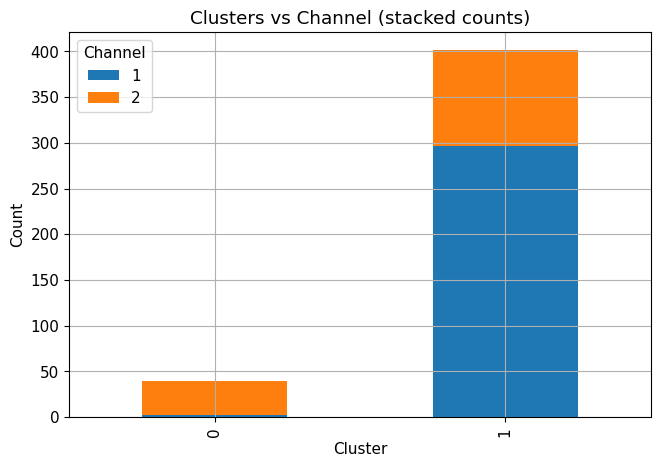

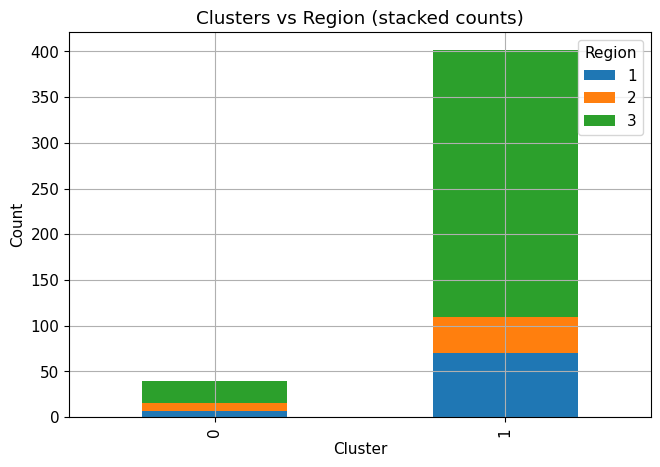

In [12]:
df_comp = df_orig.copy()
df_comp["cluster"] = labels_wh

# Crosstabs
ct_channel = pd.crosstab(df_comp["cluster"], df_comp["Channel"] if "Channel" in df_comp.columns else np.nan)
ct_region = pd.crosstab(df_comp["cluster"], df_comp["Region"] if "Region" in df_comp.columns else np.nan)

print("Cluster vs Channel:\n", ct_channel, "\n")
print("Cluster vs Region:\n", ct_region, "\n")

# Simple bar visualizations
fig = plt.figure()
ct_channel.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Clusters vs Channel (stacked counts)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

fig = plt.figure()
ct_region.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Clusters vs Region (stacked counts)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

### Problem 12 - Useful Insights for Wholesalers


Cluster sizes:
 cluster
0     39
1    401
Name: size, dtype: int64 

Cluster means:
                 Fresh          Milk       Grocery       Frozen  \
cluster                                                          
0        12078.923077  21367.948718  29886.384615  3199.641026   
1        11992.650873   4281.812968   5817.937656  3059.511222   

         Detergents_Paper   Delicassen  
cluster                                 
0            14134.974359  3781.769231  
1             1787.014963  1305.371571   

Cluster medians:
           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
cluster                                                                
0        5531.0  15726.0  24773.0  1465.0           12420.0      1543.0
1        8656.0   3234.0   3993.0  1535.0             694.0       911.0 



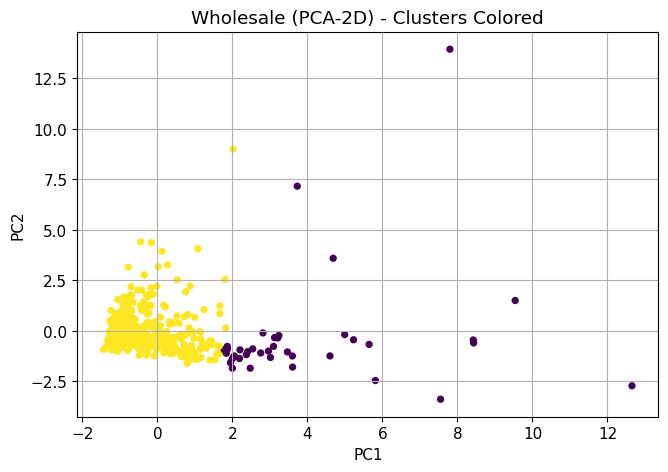

In [13]:
# Attach labels and compute per-cluster summaries
feature_cols_full = [c for c in df_orig.columns if c.lower() not in ("channel", "region")]
df_summary = df_orig[feature_cols_full].copy()
df_summary["cluster"] = labels_wh

summary_mean = df_summary.groupby("cluster").mean(numeric_only=True)
summary_median = df_summary.groupby("cluster").median(numeric_only=True)
sizes = df_summary.groupby("cluster").size().rename("size")

print("Cluster sizes:\n", sizes, "\n")
print("Cluster means:\n", summary_mean, "\n")
print("Cluster medians:\n", summary_median, "\n")

# Quick PC scatter colored by cluster (for overview)
fig = plt.figure()
plt.scatter(data_pca[:,0], data_pca[:,1], s=18, c=labels_wh)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wholesale (PCA-2D) - Clusters Colored")
plt.show()


**Notes:**
- High-spend clusters (e.g., on Milk/Grocery/Detergents_Paper) may correspond to **retail stores**; lower-spend or Fresh/Frozen-heavy clusters may be **restaurants**.
- Use per-cluster means/medians to tailor **pricing, promotions, or inventory planning**.


## 6. Other Non-Hierarchical Clustering Methods



### Problem 14 - t-SNE + DBSCAN on Wholesale Customers

We embed scaled features with **t-SNE** (2D) and cluster with **DBSCAN**. We then compare to PCA+K-means qualitatively.


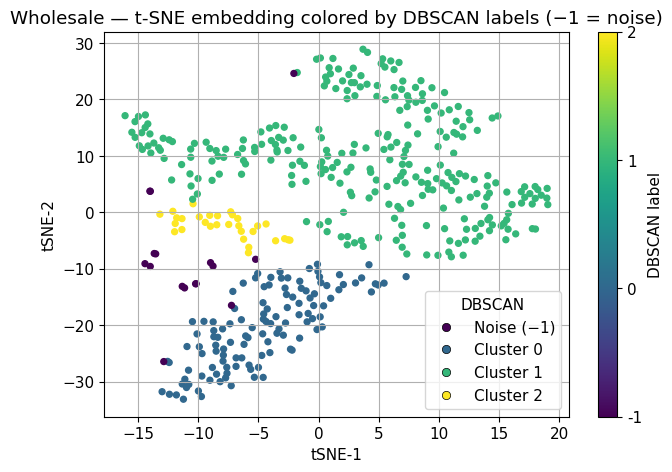

Cross-tab K-means vs DBSCAN:
 dbscan_label    -1   0    1   2
kmeans_cluster                 
0                3  35    1   0
1               13  84  274  30


In [15]:
if SKLEARN_AVAILABLE:
    # TSNE embedding
    tsne = TSNE(n_components=2, init="random", learning_rate="auto",
                perplexity=30, random_state=42)
    data_tsne = tsne.fit_transform(data_scaled)

    # DBSCAN (defaults; you may tune eps/min_samples)
    db = DBSCAN(eps=2.5, min_samples=5)
    labels_db = db.fit_predict(data_tsne)

    # Visualize t-SNE embedding with legend + colorbar
    fig = plt.figure()
    sc = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=18, c=labels_db)
    plt.title("Wholesale — t-SNE embedding colored by DBSCAN labels (−1 = noise)")
    plt.xlabel("tSNE-1")
    plt.ylabel("tSNE-2")

    # Legend entries per label (use same colormap mapping as the scatter)
    from matplotlib.lines import Line2D
    unique_labels = np.unique(labels_db)
    handles = []
    for lab in unique_labels:
        name = "Noise (−1)" if lab == -1 else f"Cluster {lab}"
        color = sc.cmap(sc.norm(lab))  # match the scatter's colormap & normalization
        handles.append(Line2D([0], [0], marker='o', linestyle='',
                              markersize=6, label=name,
                              markerfacecolor=color, markeredgecolor='k', markeredgewidth=0.5))
    plt.legend(handles=handles, title="DBSCAN")

    # Colorbar labeled with DBSCAN labels
    cbar = plt.colorbar(sc)
    cbar.set_label("DBSCAN label")
    cbar.set_ticks(unique_labels)
    cbar.set_ticklabels([str(int(v)) for v in unique_labels])

    plt.show()

    # Compare label distributions with K-means clusters
    comp = pd.crosstab(labels_wh, labels_db,
                       rownames=['kmeans_cluster'], colnames=['dbscan_label'])
    print("Cross-tab K-means vs DBSCAN:\n", comp)
else:
    print("scikit-learn not available - skipping TSNE+DBSCAN section.")